# Initial Analysis of ICIJ Data

This notebook will provide graphs and tables which show the top 10 most popular:

- Locations for entities to be based in
- Jurisdictions for entities 
- Entity types

**Note:**
Some graphs and tables here were used in our presentation and we later decided to not use them in our final paper 

In [1]:
## importing packages and libraries that we've used in class
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import matplotlib.pyplot as plt
import yaml
#import warnings
#warnings.filterwarnings("ignore")

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [2]:

addresses_df = pd.read_csv('nodes-addresses.csv')
entities_df = pd.read_csv('nodes-entities.csv')
intermediaries_df = pd.read_csv('nodes-intermediaries.csv') 
officers_df = pd.read_csv('nodes-officers.csv')
relationships_df = pd.read_csv('relationships.csv')
others_df = pd.read_csv('nodes-others.csv')

/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_16208/2247697261.py:2: DtypeWarning: Columns (2,3,6,7,10,11,12,13,14,15,16,17,20) have mixed types. Specify dtype option on import or set low_memory=False.
/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_16208/2247697261.py:5: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
merged_df = pd.read_csv('ICIJ_Merged.csv')

/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_16208/1195876193.py:1: DtypeWarning: Columns (4,5,6,7,8,10,11,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,37,39,40,41,42,43,45,46,47,48,49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
merged_df.head()

,node_id_start,node_id_end,rel_type,link,status,start_date,end_date,sourceid,address_start,name_start,...,internal_id_end,incorporation_date_end,inactivation_date_end,struck_off_date_end,dorm_date_end,status_end,service_provider_end,ibcruc_end,type_end,closed_date_end
0,10002580,14106952,registered_address,registered address,NaN,NaN,NaN,Panama Papers,STEMBRIDGE TRUST (IRELAND) LIMITED 5 THE COURT...,FUSION TRADING LIMITED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10004460,14101133,registered_address,registered address,NaN,NaN,NaN,Panama Papers,MF CORPORATE (UK) LIMITED 520 S. 7TH STREET SU...,MF CORPORATE (UK) LIMITED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10023813,14105100,registered_address,registered address,NaN,NaN,NaN,Panama Papers,REIG INVESTMENTS LLP INVISION HOUSE WILBURY WA...,REIG INVESTMENTS LLP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10023840,14100712,registered_address,registered address,NaN,NaN,NaN,Panama Papers,MARCUSSI INTERNATIONAL LLP INVISION HOUSE WILB...,MARCUSSI INTERNATIONAL LLP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10010428,14093957,registered_address,registered address,NaN,NaN,NaN,Panama Papers,COLLYER BRISTOW LLP SOLICITORS 4 BEDFORD ROW L...,PULSAR HOLDINGS CORPORATION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Top 10 Physical Bases 

Top 10 countries for entities (based on start_country, semicolon separated values counted individually):
countries_end
British Virgin Islands    56520
Aruba                     48683
Barbados                  40306
Hong Kong                 13735
Cayman Islands            10999
Bermuda                    9560
United Kingdom             9074
Russia                     7389
United States              5266
Seychelles                 3024
Name: node_id_start, dtype: int64


<Axes: xlabel='countries_end'>

Text(0.5, 1.0, 'Top 10 Countries for Entities to be physically based in')

Text(0.5, 0, '')

Text(0, 0.5, 'Number of Entities')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'British Virgin Islands'),
  Text(1, 0, 'Aruba'),
  Text(2, 0, 'Barbados'),
  Text(3, 0, 'Hong Kong'),
  Text(4, 0, 'Cayman Islands'),
  Text(5, 0, 'Bermuda'),
  Text(6, 0, 'United Kingdom'),
  Text(7, 0, 'Russia'),
  Text(8, 0, 'United States'),
  Text(9, 0, 'Seychelles')])

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000.]),
 [Text(0, 0.0, '0'),
  Text(0, 10000.0, '10000'),
  Text(0, 20000.0, '20000'),
  Text(0, 30000.0, '30000'),
  Text(0, 40000.0, '40000'),
  Text(0, 50000.0, '50000'),
  Text(0, 60000.0, '60000')])

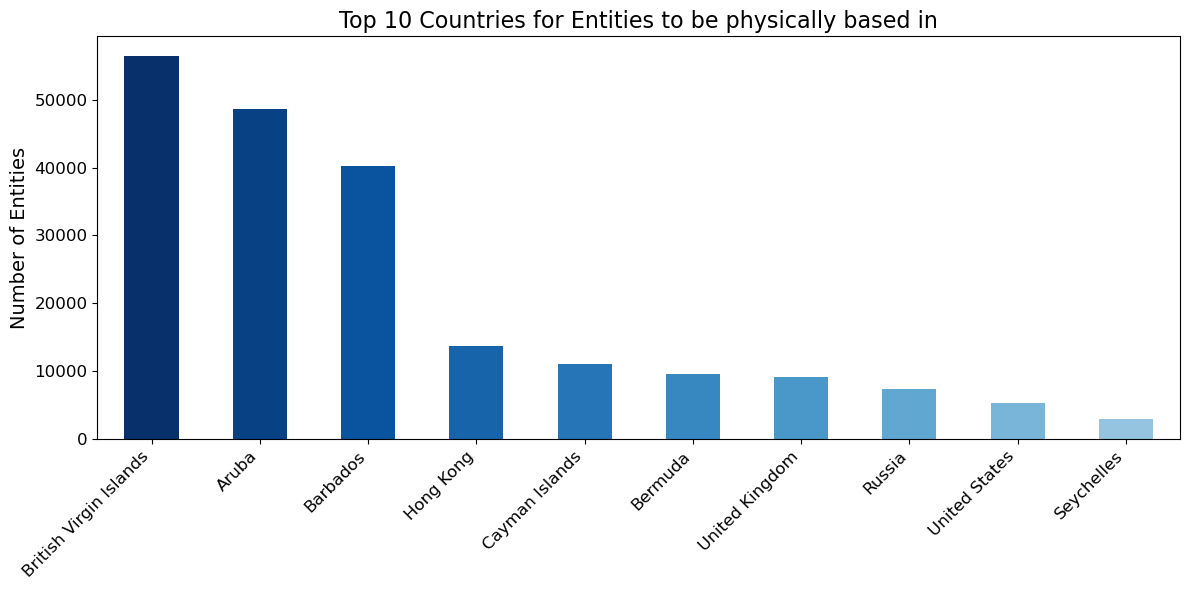

In [5]:
# Filter for rows where an "Entity" is linked to an "Address"
# (i.e. node_type_start == 'entity' and node_type_end == 'address')
entity_to_address = merged_df[
    (merged_df["node_type_start"] == "entity") & (merged_df["node_type_end"]   == "address")
]

# Count how many distinct entities are linked to each address-country
# (assuming the address country is in the column "countries_end")
top_countries = (
    entity_to_address
    .groupby("countries_end")["node_id_start"]   # "start_id" is the entity’s node ID
    .nunique()                              # count distinct entities per country
    .sort_values(ascending=False) 
)


top_10_entity_countries = top_countries.nlargest(10)

print("Top 10 countries for entities (based on start_country, semicolon separated values counted individually):")
print(top_10_entity_countries)

# Create a bar plot for the top 10 countries
# Sort the data for gradient coloring
sorted_countries = top_10_entity_countries.sort_values(ascending=False)
# Create a color map from light blue to dark blue
colors = plt.cm.Blues(np.linspace(1, 0.4, len(sorted_countries))) # Darkest for highest, lighter for lower

sorted_countries.plot(kind='bar', figsize=(12, 6), color=colors)
plt.title('Top 10 Countries for Entities to be physically based in', fontsize=16) # Increased title font size
plt.xlabel('', fontsize=1) # Increased x-label font size
plt.ylabel('Number of Entities', fontsize=14) # Increased y-label font size
plt.xticks(rotation=45, ha='right', fontsize=12) # Adjusted rotation for better label visibility and increased font size
plt.yticks(fontsize=12) # Increased y-ticks font size
plt.tight_layout()
plt.show()



### Top 10 Entity Jurisdictions

Top 10 jurisdictions for entities
jurisdiction_description
Bahamas                   209713
British Virgin Islands    172389
Malta                      83939
Saint Kitts and Nevis      70604
Aruba                      49050
Panama                     48691
Barbados                   40846
Seychelles                 16886
Samoa                      15019
Niue                        9611
Name: count, dtype: int64


<Axes: xlabel='jurisdiction_description'>

Text(0.5, 1.0, 'Top 10 Jurisdictions for Entities')

Text(0.5, 0, ' ')

Text(0, 0.5, 'Number of Entities')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Bahamas'),
  Text(1, 0, 'British Virgin Islands'),
  Text(2, 0, 'Malta'),
  Text(3, 0, 'Saint Kitts and Nevis'),
  Text(4, 0, 'Aruba'),
  Text(5, 0, 'Panama'),
  Text(6, 0, 'Barbados'),
  Text(7, 0, 'Seychelles'),
  Text(8, 0, 'Samoa'),
  Text(9, 0, 'Niue')])

(array([     0.,  25000.,  50000.,  75000., 100000., 125000., 150000.,
        175000., 200000., 225000.]),
 [Text(0, 0.0, '0'),
  Text(0, 25000.0, '25000'),
  Text(0, 50000.0, '50000'),
  Text(0, 75000.0, '75000'),
  Text(0, 100000.0, '100000'),
  Text(0, 125000.0, '125000'),
  Text(0, 150000.0, '150000'),
  Text(0, 175000.0, '175000'),
  Text(0, 200000.0, '200000'),
  Text(0, 225000.0, '225000')])

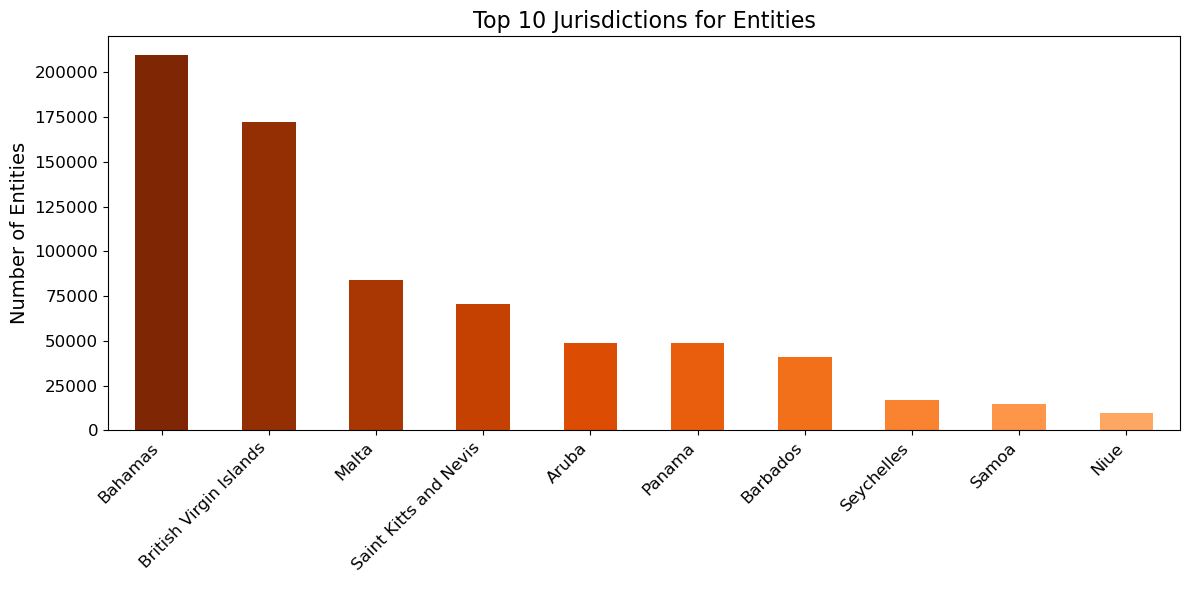

In [6]:
# Filter for entities
entity_rels2 = entities_df

# Get the top 10 jurisdictions for entities
jurisdiction_counts = entity_rels2['jurisdiction_description'].value_counts()

# Filter out "Undetermined" before getting the top 10
filtered_jurisdiction_counts = jurisdiction_counts[jurisdiction_counts.index != 'Undetermined']
top_10_entity_jurisdictions = filtered_jurisdiction_counts.nlargest(10)

print("Top 10 jurisdictions for entities")
print(top_10_entity_jurisdictions)

# Create a bar plot for the top 10 jurisdictions
# nlargest already sorts, so top_10_entity_jurisdictions is sorted.
sorted_jurisdictions = top_10_entity_jurisdictions

# Create a color map from light orange to dark orange
colors = plt.cm.Oranges(np.linspace(1, 0.4, len(sorted_jurisdictions))) # Darkest for highest, lighter for lower

sorted_jurisdictions.plot(kind='bar', figsize=(12, 6), color=colors)
plt.title('Top 10 Jurisdictions for Entities', fontsize=16) # Increased title font size
plt.xlabel(' ', fontsize=1) # Increased x-label font size
plt.ylabel('Number of Entities', fontsize=14) # Increased y-label font size
plt.xticks(rotation=45, ha='right', fontsize=12) # Added ha='right' for better label visibility and increased font size
plt.yticks(fontsize=12) # Increased y-ticks font size
plt.tight_layout()
plt.show()



In [7]:
entities_df.head()

,node_id,name,original_name,former_name,jurisdiction,jurisdiction_description,company_type,address,internal_id,incorporation_date,...,struck_off_date,dorm_date,status,service_provider,ibcRUC,country_codes,countries,sourceID,valid_until,note
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.","TIANSHENG INDUSTRY AND TRADING CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001256.0,23-MAR-2006,...,15-FEB-2013,NaN,Defaulted,Mossack Fonseca,25221,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.","NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001263.0,27-MAR-2006,...,15-FEB-2014,NaN,Defaulted,Mossack Fonseca,25249,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
2,10000003,"HOTFOCUS CO., LTD.","HOTFOCUS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000896.0,10-JAN-2006,...,15-FEB-2012,NaN,Defaulted,Mossack Fonseca,24138,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
3,10000004,"SKY-BLUE GIFTS & TOYS CO., LTD.","SKY-BLUE GIFTS & TOYS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000914.0,06-JAN-2006,...,15-FEB-2009,NaN,Defaulted,Mossack Fonseca,24012,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
4,10000005,FORTUNEMAKER INVESTMENTS CORPORATION,FORTUNEMAKER INVESTMENTS CORPORATION,NaN,SAM,Samoa,NaN,LOYAL PORT LIMITED 8/F; CRAWFORD TOWER 99 JERV...,1001266.0,19-APR-2006,...,15-FEB-2008,NaN,Changed agent,Mossack Fonseca,R25638,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN


### Top 10 Entity Types (note: we only used this for the presentation and decided not to use it for the final paper)

Top 10 entity types:
company_type
Standard International Company                 40072
Standard Company under IBC Act                 26214
Business Company Limited by Shares             25130
Regular (Local) Company                        17599
Business Corporation                           16244
Client Sundry Account                           8692
International Trust                              999
Cook Islands Asset Protection Trust              547
Domestic Company                                 462
Cook Islands Asset Protection Trust - 3520A      445
Name: count, dtype: int64


<Axes: xlabel='company_type'>

Text(0.5, 1.0, 'Top 10 Entity Types')

Text(0.5, 0, ' ')

Text(0, 0.5, 'Number of Entities')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Standard International Company'),
  Text(1, 0, 'Standard Company under IBC Act'),
  Text(2, 0, 'Business Company Limited by Shares'),
  Text(3, 0, 'Regular (Local) Company'),
  Text(4, 0, 'Business Corporation'),
  Text(5, 0, 'Client Sundry Account'),
  Text(6, 0, 'International Trust'),
  Text(7, 0, 'Cook Islands Asset Protection Trust'),
  Text(8, 0, 'Domestic Company'),
  Text(9, 0, 'Cook Islands Asset Protection Trust - 3520A')])

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000., 45000.]),
 [Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000'),
  Text(0, 20000.0, '20000'),
  Text(0, 25000.0, '25000'),
  Text(0, 30000.0, '30000'),
  Text(0, 35000.0, '35000'),
  Text(0, 40000.0, '40000'),
  Text(0, 45000.0, '45000')])

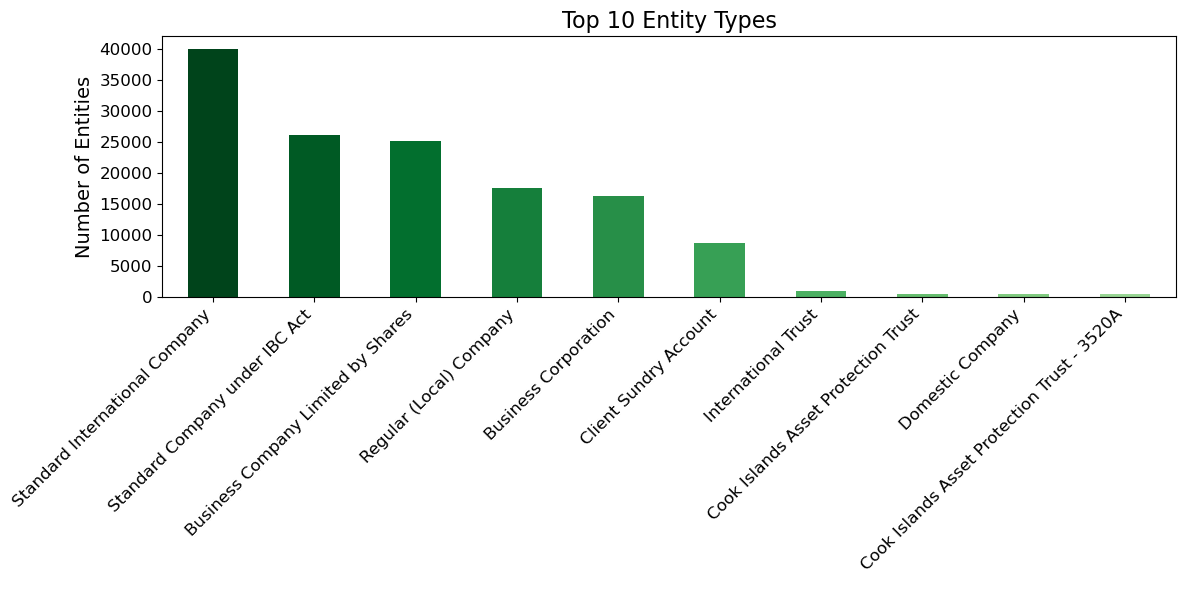

In [8]:
# getting the top 10 entity types
entity_type_counts = entities_df['company_type'].value_counts()
top_10_entity_types = entity_type_counts.nlargest(10)

print("Top 10 entity types:")
print(top_10_entity_types)

# Create a bar plot for the top 10 entity types
# Sort the data for gradient coloring
sorted_entity_types = top_10_entity_types.sort_values(ascending=False)

# Create a color map from light green to dark green
colors = plt.cm.Greens(np.linspace(1, 0.4, len(sorted_entity_types))) # Darkest for highest, lighter for lower

sorted_entity_types.plot(kind='bar', figsize=(12, 6), color=colors)
plt.title('Top 10 Entity Types', fontsize=16) # Increased title font size for better readability
plt.xlabel(' ', fontsize=1) # Increased x-label font size
plt.ylabel('Number of Entities', fontsize=14) # Increased y-label font size
plt.xticks(rotation=45, ha='right', fontsize=12) # Increased x-ticks font size
plt.yticks(fontsize=12) # Added y-ticks font size
plt.tight_layout()
plt.show()

In [9]:
# Convert Series to DataFrames for better display and add a rank

# Top 10 Countries for Entities
# The Series top_10_entity_countries has an index named 'countries_end' and values representing counts.
df_countries = top_10_entity_countries.reset_index()
df_countries.columns = ['Country', 'Number of Entities'] # Rename columns for clarity
df_countries.index = np.arange(1, len(df_countries) + 1) # Create a 1-based rank index
df_countries.index.name = 'Rank'

# Top 10 Jurisdictions for Entities
# The Series top_10_entity_jurisdictions has an index named 'jurisdiction_description'.
df_jurisdictions = top_10_entity_jurisdictions.reset_index()
df_jurisdictions.columns = ['Jurisdiction', 'Number of Entities'] # Rename columns
df_jurisdictions.index = np.arange(1, len(df_jurisdictions) + 1) # Create a 1-based rank index
df_jurisdictions.index.name = 'Rank'

# Top 10 Entity Types
# The Series top_10_entity_types has an index named 'company_type'.
df_entity_types = top_10_entity_types.reset_index()
df_entity_types.columns = ['Entity Type', 'Number of Entities'] # Rename columns
df_entity_types.index = np.arange(1, len(df_entity_types) + 1) # Create a 1-based rank index
df_entity_types.index.name = 'Rank'

print("Top 10 Countries for Entities (based on physical address):")
display(df_countries)
# uncomment the line below to save this as a CSV file:
# df_countries.to_csv('top_10_entity_countries_ranked.csv')
print("\n")

print("Top 10 Jurisdictions for Entities:")
display(df_jurisdictions)
# uncomment the line below to save this as a CSV file:
# df_jurisdictions.to_csv('top_10_entity_jurisdictions_ranked.csv')
print("\n")

print("Top 10 Entity Types:")
display(df_entity_types)
# uncomment the line below to save this as a CSV file:
# df_entity_types.to_csv('top_10_entity_types_ranked.csv')


Top 10 Countries for Entities (based on physical address):


,Country,Number of Entities
Rank,,
1,British Virgin Islands,56520
2,Aruba,48683
3,Barbados,40306
4,Hong Kong,13735
5,Cayman Islands,10999
6,Bermuda,9560
7,United Kingdom,9074
8,Russia,7389
9,United States,5266




Top 10 Jurisdictions for Entities:


,Jurisdiction,Number of Entities
Rank,,
1,Bahamas,209713
2,British Virgin Islands,172389
3,Malta,83939
4,Saint Kitts and Nevis,70604
5,Aruba,49050
6,Panama,48691
7,Barbados,40846
8,Seychelles,16886
9,Samoa,15019




Top 10 Entity Types:


,Entity Type,Number of Entities
Rank,,
1,Standard International Company,40072
2,Standard Company under IBC Act,26214
3,Business Company Limited by Shares,25130
4,Regular (Local) Company,17599
5,Business Corporation,16244
6,Client Sundry Account,8692
7,International Trust,999
8,Cook Islands Asset Protection Trust,547
9,Domestic Company,462


### Table that shows each top 10 previously extracted from the dataset (physical bases, entity jurisdictions, and entity types)

#### We used this table for the final presentation

In [10]:
# Extract the names (indices) from each Series
countries_list = top_10_entity_countries.index.tolist()
jurisdictions_list = top_10_entity_jurisdictions.index.tolist()
entity_types_list = top_10_entity_types.index.tolist()


max_len = 10 

countries_list_padded = (countries_list + [None] * max_len)[:max_len]
jurisdictions_list_padded = (jurisdictions_list + [None] * max_len)[:max_len]
entity_types_list_padded = (entity_types_list + [None] * max_len)[:max_len]


# Create a new dataframe with padded lists
combined_top_10_df = pd.DataFrame({
    "Top 10 countries for entities to be physically based in": countries_list_padded,
    "Top 10 jurisdictions for entities": jurisdictions_list_padded,
    "Top 10 entity types": entity_types_list_padded
})

# Set the index to start from 1
combined_top_10_df.index = np.arange(1, len(combined_top_10_df) + 1)

# showing combinded dataframe
combined_top_10_df

,Top 10 countries for entities to be physically based in,Top 10 jurisdictions for entities,Top 10 entity types
1,British Virgin Islands,Bahamas,Standard International Company
2,Aruba,British Virgin Islands,Standard Company under IBC Act
3,Barbados,Malta,Business Company Limited by Shares
4,Hong Kong,Saint Kitts and Nevis,Regular (Local) Company
5,Cayman Islands,Aruba,Business Corporation
6,Bermuda,Panama,Client Sundry Account
7,United Kingdom,Barbados,International Trust
8,Russia,Seychelles,Cook Islands Asset Protection Trust
9,United States,Samoa,Domestic Company
10,Seychelles,Niue,Cook Islands Asset Protection Trust - 3520A
